In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings

In [2]:
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    print(f'Đã tải lên file "{filename}" với kích thước {len(uploaded[filename])} bytes')

Saving creditcard.csv to creditcard.csv
Đã tải lên file "creditcard.csv" với kích thước 150828752 bytes


In [3]:
from google.colab import drive

df = pd.read_csv('creditcard.csv')
# Đọc file CSV vào dataframe



In [4]:
import pandas as pd

def read_and_explore_data(file_path):
    print("1. Đọc và khai phá dữ liệu")
    print("-"*50)

    df = pd.read_csv(file_path)
    print(f"Kích thước dữ liệu: {df.shape}")

    print("\nThông tin dữ liệu:")
    print(df.info())

    print("\nKiểm tra giá trị thiếu:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "Không có giá trị Missing Value")

    print("\nThống kê mô tả:")
    print(df.describe())

    print("\nKiểm tra phân phối nhãn (Fraud vs Non - Fraud):")
    fraud_count = df['Class'].value_counts()
    print(fraud_count)

    print(f"Phần trăm nhãn Non - Fraud: {100*fraud_count[0]/len(df):.2f} %")
    print(f"Phần trăm nhãn Fraud: {100*fraud_count[1]/len(df):.2f} %")

    return df


In [5]:
df = read_and_explore_data('/content/creditcard.csv')


1. Đọc và khai phá dữ liệu
--------------------------------------------------
Kích thước dữ liệu: (284807, 31)

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float6

2. PHÂN TÍCH VÀ TRỰC QUAN HÓA DỮ LIỆU
--------------------------------------------------


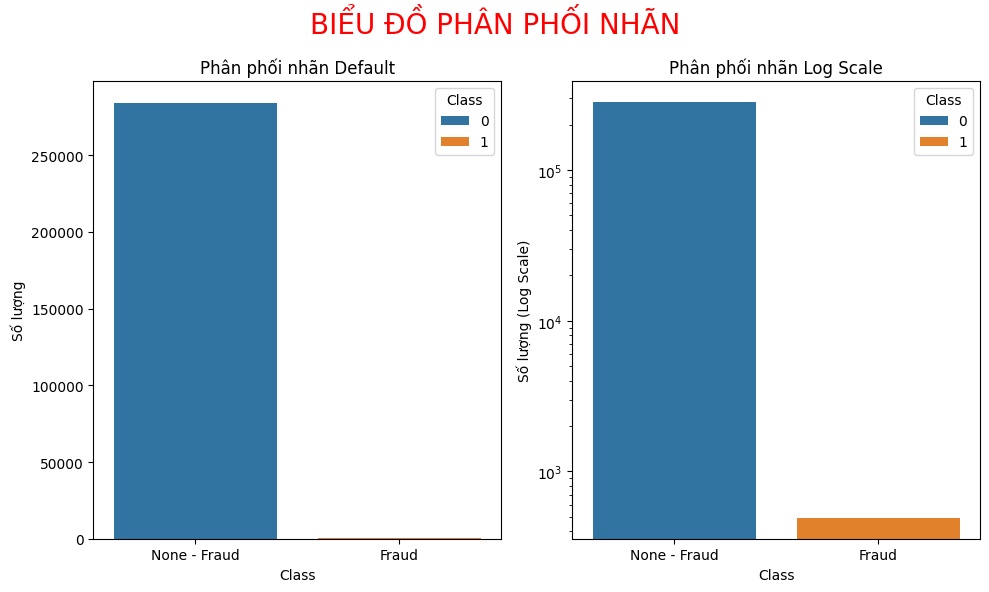

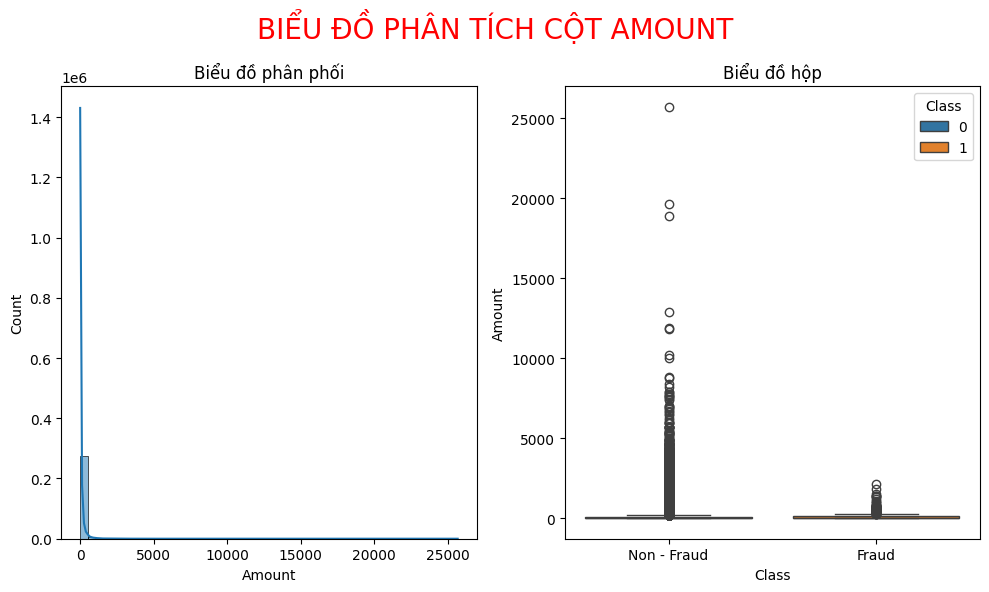

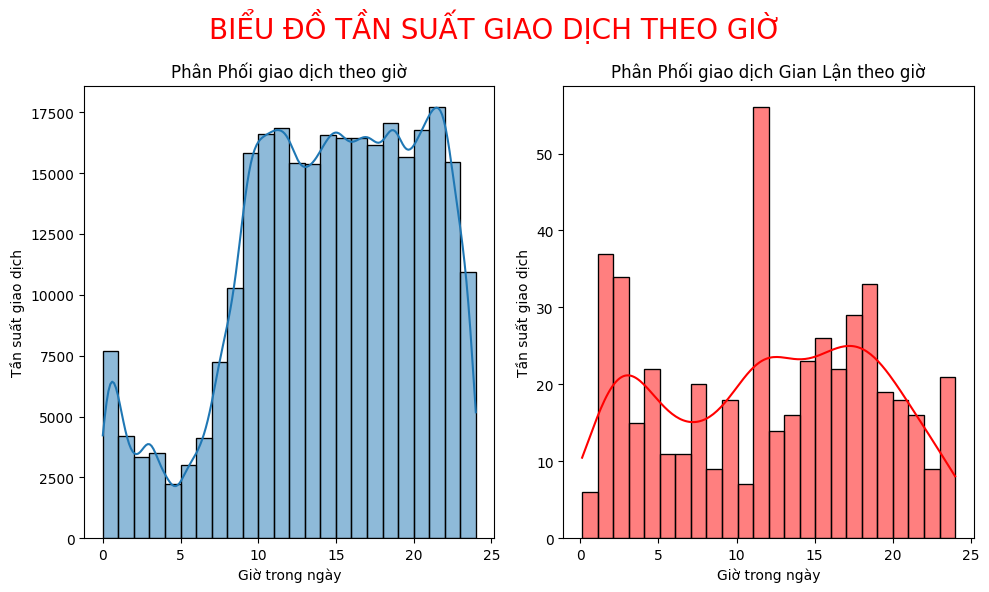

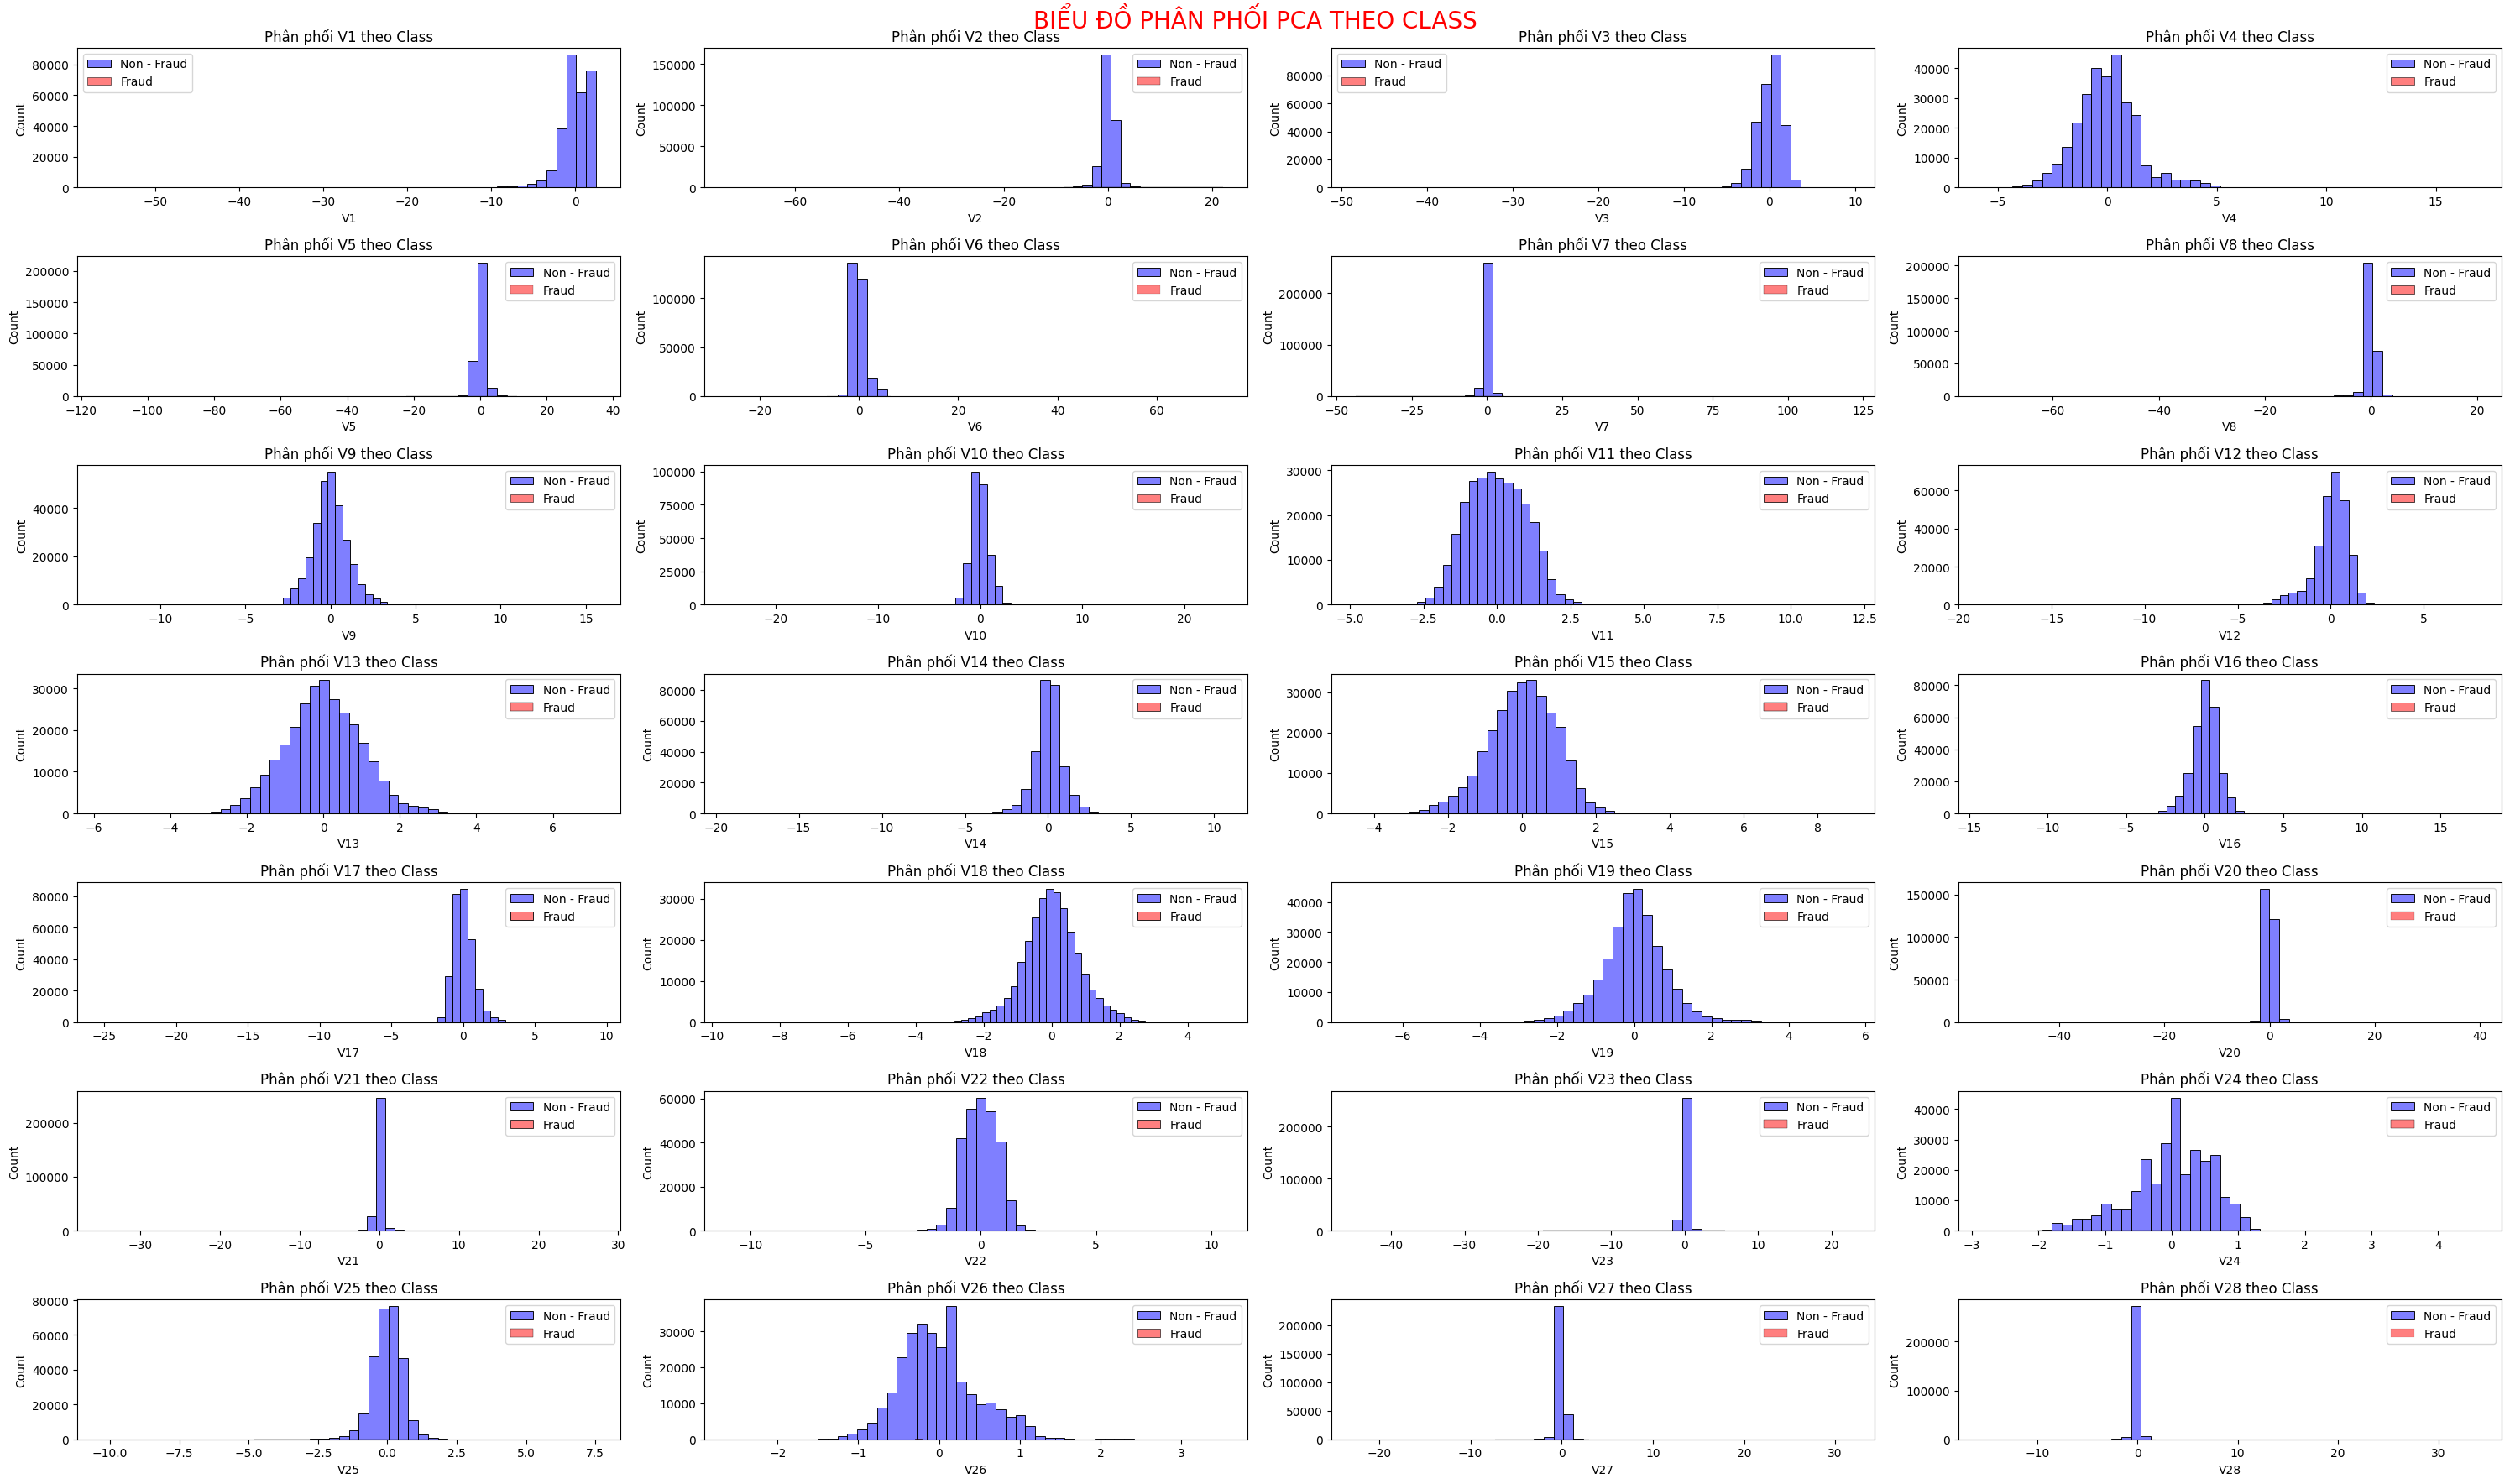

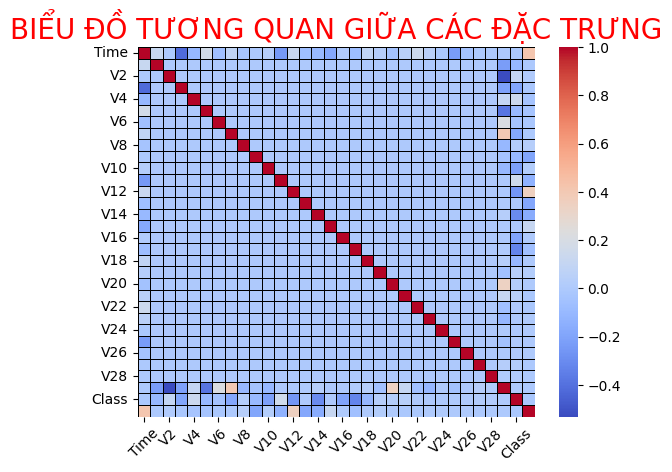

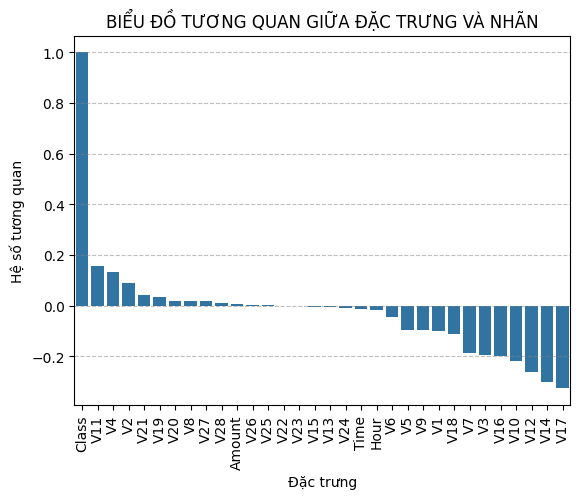

In [6]:
def analyze_and_visualize_data(df):
    print("2. PHÂN TÍCH VÀ TRỰC QUAN HÓA DỮ LIỆU")
    print("-"*50)

    # 2.1. Phân tích và trực quan hóa biến mục tiêu
    fig1 = plt.figure(figsize = (10, 6))

    plt.subplot(1,2,1)
    sns.countplot(data = df, x = 'Class', hue = 'Class')
    plt.title("Phân phối nhãn Default")
    plt.xlabel("Class")
    plt.ylabel("Số lượng")
    plt.xticks([0,1], ['None - Fraud', 'Fraud'])

    plt.subplot(1,2,2)
    sns.countplot(data = df, x = 'Class', hue = 'Class')
    plt.title("Phân phối nhãn Log Scale")
    plt.xlabel("Class")
    plt.ylabel("Số lượng (Log Scale)")
    plt.yscale('log')
    plt.xticks([0,1], ['None - Fraud', 'Fraud'])

    fig1.suptitle("BIỂU ĐỒ PHÂN PHỐI NHÃN", fontsize = 20, color = 'red')
    plt.tight_layout()
    plt.show()

    # 2.2. Phân tích và trực quan hóa cột Amount
    fig2 = plt.figure(figsize = (10,6))

    # Biểu đồ histogram
    plt.subplot(1,2,1)
    sns.histplot(data = df['Amount'], bins = 50, kde = True)
    plt.title("Biểu đồ phân phối")

    # Biểu đồ box
    plt.subplot(1,2,2)
    sns.boxplot(data = df, x = 'Class', y = 'Amount', hue = 'Class')
    plt.title("Biểu đồ hộp")
    plt.xticks([0,1], ['Non - Fraud', 'Fraud'])

    fig2.suptitle("BIỂU ĐỒ PHÂN TÍCH CỘT AMOUNT", fontsize = 20,color = 'red')
    plt.tight_layout()
    plt.show()

    # 2.3. Phân tích và trực quan hóa cột Time
    fig3 = plt.figure(figsize = (10,6))

    # Tạo cột 'hour' trong df
    df['Hour'] = df['Time']/3600%24

    # Biểu đồ phân phối giao dịch theo giờ
    plt.subplot(1,2,1)
    sns.histplot(data = df['Hour'], kde = True, bins = 24)
    plt.title("Phân Phối giao dịch theo giờ")
    plt.xlabel("Giờ trong ngày")
    plt.ylabel("Tần suất giao dịch")

    # Biểu đồ phân phối giao dịch Gian Lận theo giờ
    plt.subplot(1,2,2)
    sns.histplot(data = df['Hour'][df['Class'] == 1], bins = 24, kde = True, color = 'red')
    plt.title("Phân Phối giao dịch Gian Lận theo giờ")
    plt.xlabel("Giờ trong ngày")
    plt.ylabel("Tần suất giao dịch")

    fig3.suptitle("BIỂU ĐỒ TẦN SUẤT GIAO DỊCH THEO GIỜ", fontsize = 20, color = 'red')
    plt.tight_layout()
    plt.show()

    # 2.4 Phân tích và trực quan các đặc trưng PCA
    fig4 = plt.figure(figsize = (30, 18))
    pca_features = [f"V{i}" for i in range(1,29)]

    for i, feature in enumerate(pca_features):
        plt.subplot(7, 4, i+1)
        sns.histplot(df[df['Class'] == 0][feature], bins = 50, color = 'blue', alpha = 0.5, label = 'Non - Fraud')
        sns.histplot(df[df['Class'] == 1][feature], bins = 50, color = 'red', alpha = 0.5, label = 'Fraud')
        plt.title(f"Phân phối {feature} theo Class")
        plt.xlabel(feature)
        plt.legend()

    fig4 = plt.suptitle("BIỂU ĐỒ PHÂN PHỐI PCA THEO CLASS", fontsize = 20, color = 'red')
    plt.tight_layout()
    plt.show()

    #2.5.1 Phân tích và vẽ biểu đồ TƯƠNG QUAN giữa các đặc trưng
    df_heat = df.corr()

    sns.heatmap(data = df_heat, annot = False, cmap = 'coolwarm', linecolor = 'black', linewidth = 0.5)
    plt.title("BIỂU ĐỒ TƯƠNG QUAN GIỮA CÁC ĐẶC TRƯNG", fontsize = 20, color = 'red')
    plt.xticks(rotation = 45)
    plt.show()

    # 2.5.2 Phân tích tương quan với biến mục tiêu
    df_cor_target = df_heat["Class"].sort_values(ascending = False)
    sns.barplot(x = df_cor_target.index, y = df_cor_target.values)
    plt.title("BIỂU ĐỒ TƯƠNG QUAN GIỮA ĐẶC TRƯNG VÀ NHÃN")
    plt.xlabel("Đặc trưng")
    plt.ylabel("Hệ số tương quan")
    plt.xticks(rotation = 90)
    plt.grid(axis = 'y', linestyle = '--', color = 'gray', alpha = 0.5)
    plt.show()

    return df
df = analyze_and_visualize_data(df)

In [7]:
# Module hóa
def add_is_night(df):
    df['Is_Night'] = ((df['Hour'] >= 0) & (df['Hour'] <= 5)).astype(int)
    print("Đã thêm đặc trưng Is_Night vào Data")
    print("-"*100)
    return df

def add_High_Amount(df):
      # df = add_High_Amount(df)
    df['High_Amount'] = (df['Amount'] > 1000).astype(int)
    print("Đã thêm đặc trưng High_Amount vào Data")
    print("-"*100)
    return df

def add_Amount_Bins(df):
    bins = [0, 100, 500, 1000, 5000, 2000000]
    labels = [0, 1, 2, 3, 4]
    df['Amount_Bins'] = pd.cut(df['Amount'], bins = bins, labels = labels, include_lowest=True)
    df['Amount_Bins'] = df['Amount_Bins'].astype(int)
    print("Đã thêm đặc trưng Amount_Bins vào Data")
    print("-"*100)
    return df

def add_High_Amount_at_Night(df):
    df['High_Amount_at_Night'] = (df['High_Amount'] & df['Is_Night']).astype(int)
    print("Đã thêm đặc trưng High_Amount_at_Night vào Data")
    print("-"*100)

    return df

def analize_binary_feature(df, col, target = 'Class', Viz = False):
    print(f"Phân tích đặc trưng {col}:")
    print("-"*100)
    print(df[col].value_counts())
    dataa = df.groupby(col)[target].mean()
    print(dataa)

    if Viz:
        print(f"Trực quan hóa cột {col}:")
        print("-"*100)

        fig1 = plt.figure(figsize = (14, 8))

        # Biểu đồ thứ nhất
        plt.subplot(1,2,1)
        sns.countplot(data = df, x = col, hue = target)
        plt.yscale('log')
        plt.title(f'Phân tích Fraud - {col}')
        plt.xlabel(col)
        plt.ylabel('Tần suất xuất hiện (Log Scale)')

        # Biểu đồ thứ hai
        plt.subplot(1,2,2)
        # Phương pháp 2: Chuyển Series thành DataFrame và vẽ bằng seaborn
        dataa_df = dataa.reset_index()  # Chuyển Series thành DataFrame
        dataa_df.columns = [col, target]  # Đặt tên cho các cột

        sns.barplot(data = dataa_df, x= col, y= target, hue = col)
        plt.title(f'Giá trị trung bình của {target} theo {col}')
        plt.ylabel(f'Giá trị trung bình của {target}')

        fig1.suptitle(f"BIỂU ĐỒ PHÂN TÍCH BIẾN {col}", fontsize = 25, color = 'red')
        plt.tight_layout()

        plt.show()
        print("-"*100)

3. TIỀN XỬ LÝ DỮ LIỆU
----------------------------------------------------------------------------------------------------

 Tiến hành thêm đặc trưng:
Đã thêm đặc trưng Is_Night vào Data
----------------------------------------------------------------------------------------------------
Phân tích đặc trưng Is_Night:
----------------------------------------------------------------------------------------------------
Is_Night
0    263862
1     20945
Name: count, dtype: int64
Is_Night
0    0.001436
1    0.005395
Name: Class, dtype: float64
Trực quan hóa cột Is_Night:
----------------------------------------------------------------------------------------------------


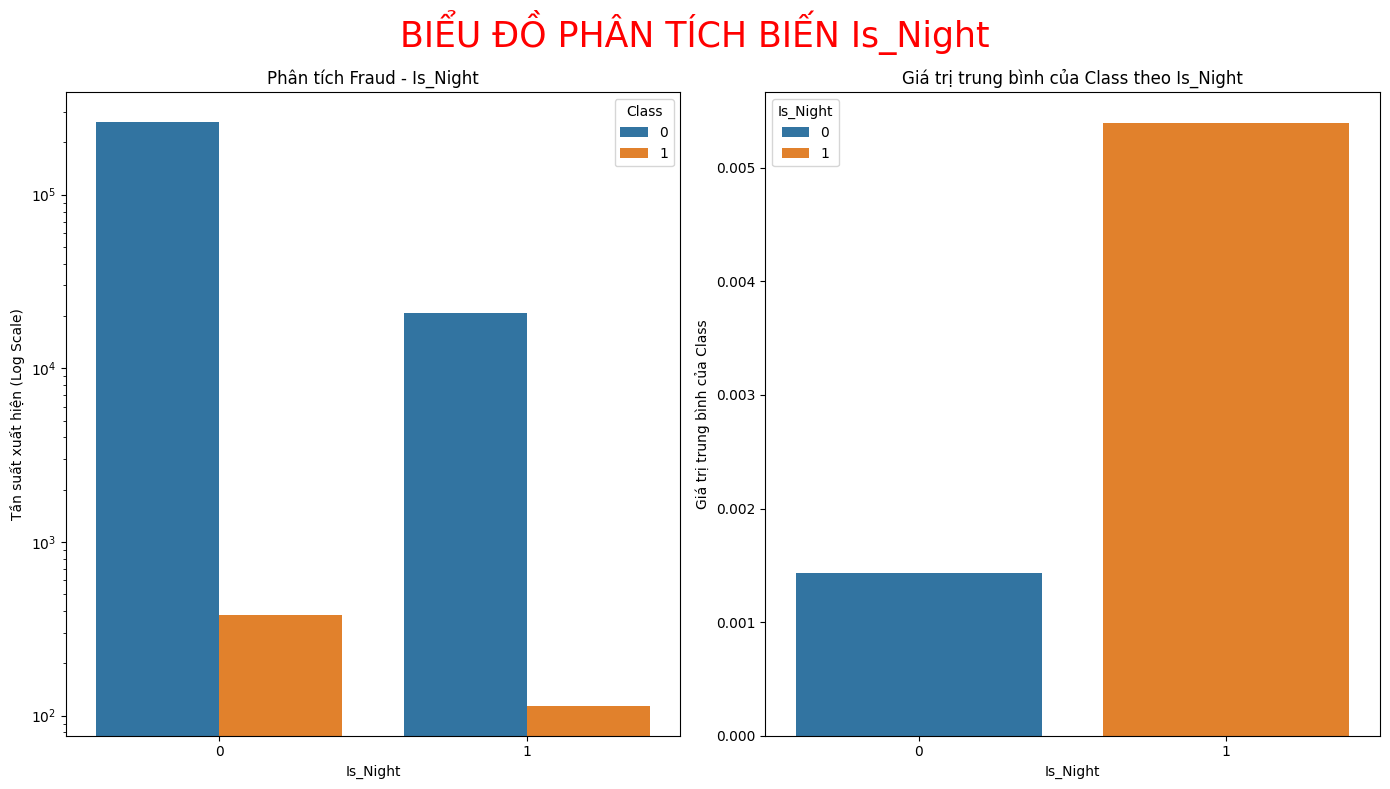

----------------------------------------------------------------------------------------------------
Đã thêm đặc trưng High_Amount vào Data
----------------------------------------------------------------------------------------------------
Phân tích đặc trưng High_Amount:
----------------------------------------------------------------------------------------------------
High_Amount
0    281867
1      2940
Name: count, dtype: int64
High_Amount
0    0.001714
1    0.003061
Name: Class, dtype: float64
Trực quan hóa cột High_Amount:
----------------------------------------------------------------------------------------------------


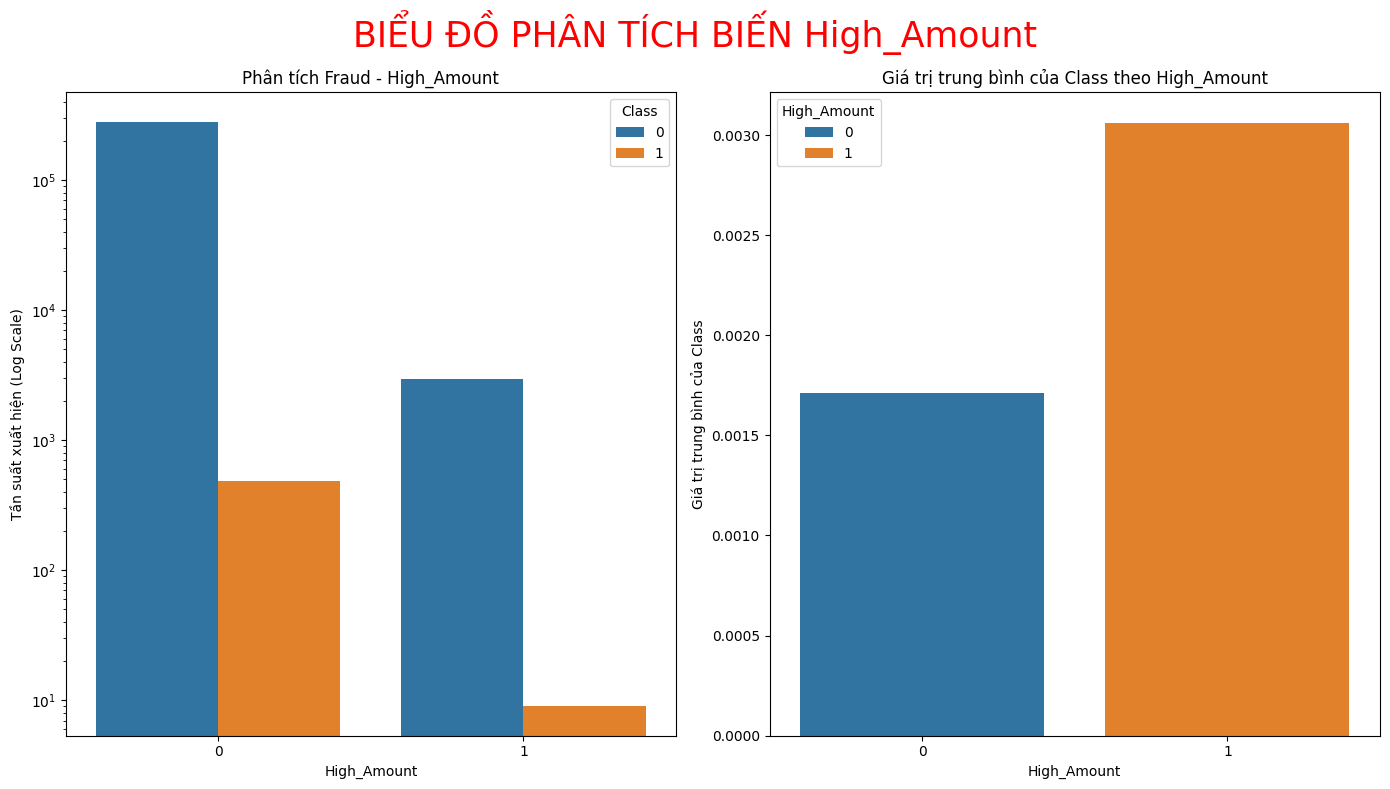

----------------------------------------------------------------------------------------------------
Đã thêm đặc trưng Amount_Bins vào Data
----------------------------------------------------------------------------------------------------
Phân tích đặc trưng Amount_Bins:
----------------------------------------------------------------------------------------------------
Amount_Bins
0    228299
1     47366
2      6202
3      2885
4        55
Name: count, dtype: int64
Amount_Bins
0    0.001586
1    0.002006
2    0.004192
3    0.003120
4    0.000000
Name: Class, dtype: float64
Trực quan hóa cột Amount_Bins:
----------------------------------------------------------------------------------------------------


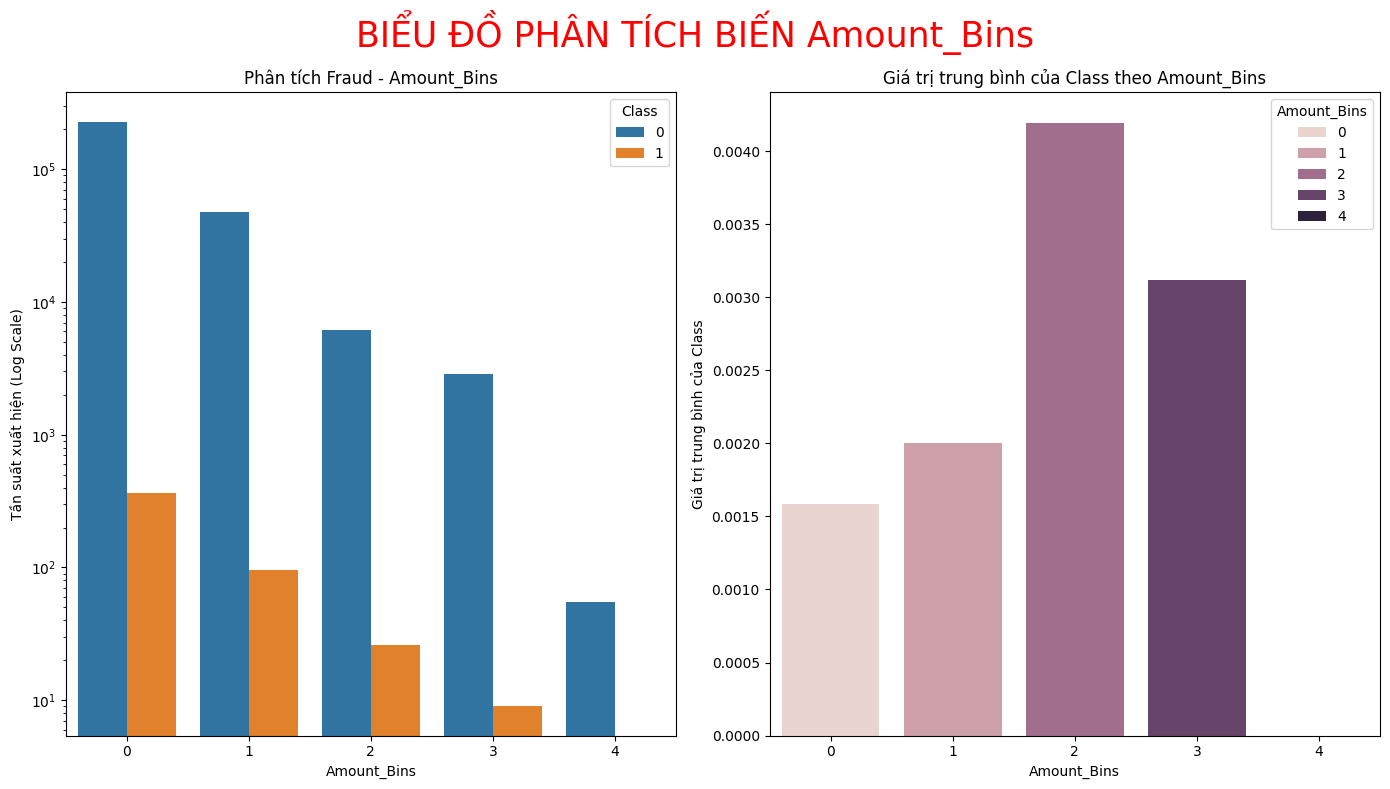

----------------------------------------------------------------------------------------------------
Đã thêm đặc trưng High_Amount_at_Night vào Data
----------------------------------------------------------------------------------------------------
Phân tích đặc trưng High_Amount_at_Night:
----------------------------------------------------------------------------------------------------
High_Amount_at_Night
0    284694
1       113
Name: count, dtype: int64
High_Amount_at_Night
0    0.001725
1    0.008850
Name: Class, dtype: float64
Trực quan hóa cột High_Amount_at_Night:
----------------------------------------------------------------------------------------------------


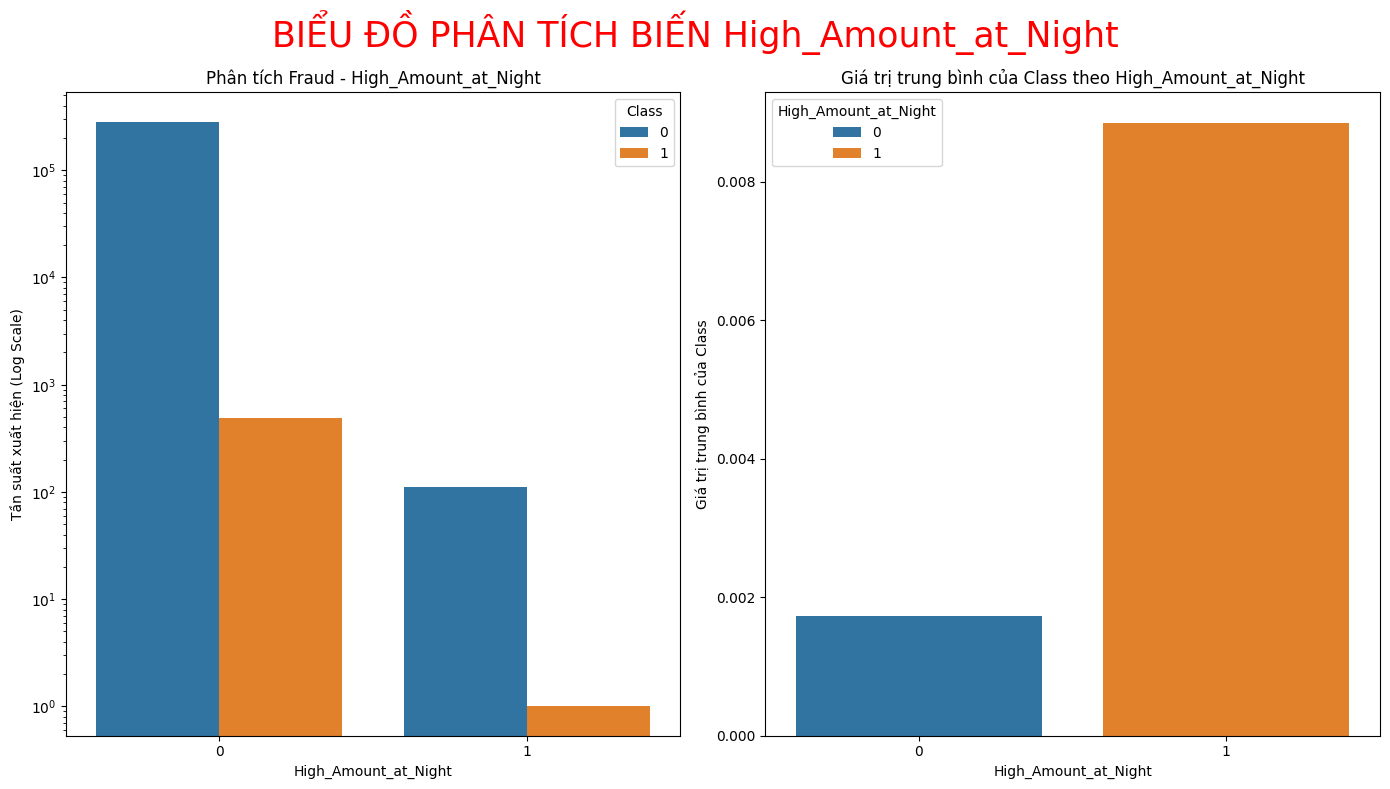

----------------------------------------------------------------------------------------------------
Tiến hành tách biến đặc trưng và mục tiêu!
----------------------------------------------------------------------------------------------------
Tiến hành chia tập huấn luyện!

Tỷ lệ nhãn Fraud trong tập train:  0.001729245759178389
Tỷ lệ nhãn Fraud trong tập test:  0.0017204452090867595


In [8]:
#Tiền xử lý dữ liệu
def preprocessing_data(df):
    print("3. TIỀN XỬ LÝ DỮ LIỆU")
    print("-"*100)

    print("\n Tiến hành thêm đặc trưng:")
    df = add_is_night(df)
    analize_binary_feature(df, col = 'Is_Night', Viz = True)

    df = add_High_Amount(df)
    analize_binary_feature(df, col = 'High_Amount', Viz = True)

    df = add_Amount_Bins(df)
    analize_binary_feature(df, col = 'Amount_Bins', Viz = True)

    df = add_High_Amount_at_Night(df)
    analize_binary_feature(df, col='High_Amount_at_Night', Viz=True)

    print("Tiến hành tách biến đặc trưng và mục tiêu!")
    X = df.drop(['Class', 'Time'], axis = 1)
    y = df['Class']
    print("-"*100)
    print("Tiến hành chia tập huấn luyện!\n")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    print("Tỷ lệ nhãn Fraud trong tập train: ", Counter(y_train)[1]/len(X_train))
    print("Tỷ lệ nhãn Fraud trong tập test: ", Counter(y_test)[1]/len(X_test))

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = preprocessing_data(df)

Xử lý dữ liệu

In [9]:
def handle_imbalanced_data(X_train, y_train):
    print("XỬ LÝ MẤT CÂN BẰNG DỮ LIỆU:")
    print("-"*100)

    # 4.1 In ra phân phối nhãn ban đầu
    print("Phân phối ban đầu: ", Counter(y_train))
    print("-"*100)

    print('Random Under-sampling')
    rus = RandomUnderSampler(sampling_strategy = 0.1, random_state=42)
    X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
    print("Phân phối sau Random Under-sampling: ", Counter(y_train_rus))
    print("-"*100)

    print("Thực hiện kỹ thuật Smote:")
    smote = SMOTE(sampling_strategy = 0.1, random_state = 42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print("Phân phối sau SMOTE: ", Counter(y_train_smote))
    print("-"*100)

    print("Thực hiện kỹ thuật Us-Smote: ")
    rus_smote = RandomUnderSampler(sampling_strategy = 0.5, random_state = 42)
    X_train_rus_smote, y_train_rus_smote = rus_smote.fit_resample(X_train_smote, y_train_smote)
    print("Phân phối sau rus - SMOTE: ", Counter(y_train_rus_smote))
    print("-"*100)

    return {
        'original':(X_train, y_train),
        'undersampling': (X_train_rus, y_train_rus),
        'smote': (X_train_smote, y_train_smote),
        'combined': (X_train_rus_smote, y_train_rus_smote)
    }
resampled_data = handle_imbalanced_data(X_train, y_train)



XỬ LÝ MẤT CÂN BẰNG DỮ LIỆU:
----------------------------------------------------------------------------------------------------
Phân phối ban đầu:  Counter({0: 227451, 1: 394})
----------------------------------------------------------------------------------------------------
Random Under-sampling
Phân phối sau Random Under-sampling:  Counter({0: 3940, 1: 394})
----------------------------------------------------------------------------------------------------
Thực hiện kỹ thuật Smote:
Phân phối sau SMOTE:  Counter({0: 227451, 1: 22745})
----------------------------------------------------------------------------------------------------
Thực hiện kỹ thuật Us-Smote: 
Phân phối sau rus - SMOTE:  Counter({0: 45490, 1: 22745})
----------------------------------------------------------------------------------------------------


In [10]:
# 5. Huấn luyện và đánh giá mô hình
def train_and_evaluate_models(resampled_data, X_test, y_test):
    print("\n5. HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH")
    print("-" * 50)

    # Danh sách các mô hình sẽ sử dụng
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    # Danh sách các phương pháp xử lý mất cân bằng
    resampling_methods = ['original', 'undersampling', 'smote', 'combined']

    # Lưu trữ kết quả
    results = {}

    for method in resampling_methods:
        print(f"\nPhương pháp xử lý dữ liệu: {method}")
        X_train_resampled, y_train_resampled = resampled_data[method]

        for model_name, model in models.items():
            print(f"\nMô hình: {model_name}")
            model.fit(X_train_resampled, y_train_resampled)

            y_pred = model.predict(X_test)

            # Đánh giá mô hình
            print(f"Classification Report cho {model_name} với phương pháp {method}:")
            print(classification_report(y_test, y_pred))

            # Tính toán điểm số cho ROC-AUC và PR-AUC
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]

                # ROC-AUC
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                roc_auc = auc(fpr, tpr)

                # PR-AUC
                precision, recall, _ = precision_recall_curve(y_test, y_prob)
                pr_auc = auc(recall, precision)

                print(f"ROC-AUC: {roc_auc:.4f}")
                print(f"PR-AUC: {pr_auc:.4f}")

                # Lưu kết quả
                if method not in results:
                    results[method] = {}
                results[method][model_name] = {
                    'model': model,
                    'y_pred': y_pred,
                    'y_prob': y_prob,
                    'roc_auc': roc_auc,
                    'pr_auc': pr_auc
                }

    return results

In [11]:
# 6. Trực quan hóa kết quả mô hình
def visualize_model_results(results, X_test, y_test):
    """
    Trực quan hóa kết quả của các mô hình
    """
    print("\n6. TRỰC QUAN HÓA KẾT QUẢ MÔ HÌNH")
    print("-" * 50)
    plt.figure(figsize=(14, 10))

    for i, method in enumerate(results.keys()):
        plt.subplot(2, 2, i+1)

        for model_name, result in results[method].items():
            y_prob = result['y_prob']
            roc_auc = result['roc_auc']

            fpr, tpr, _ = roc_curve(y_test, y_prob)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {method}')
        plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # Vẽ đường cong Precision-Recall cho mỗi phương pháp xử lý dữ liệu
    plt.figure(figsize=(14, 10))

    for i, method in enumerate(results.keys()):
        plt.subplot(2, 2, i+1)

        for model_name, result in results[method].items():
            y_prob = result['y_prob']
            pr_auc = result['pr_auc']

            precision, recall, _ = precision_recall_curve(y_test, y_prob)
            plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.4f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {method}')
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Vẽ ma trận nhầm lẫn cho mô hình tốt nhất
    best_method = max(results.keys(), key=lambda method:
                      max(results[method].values(), key=lambda x: x['pr_auc'])['pr_auc'])
    best_model_name = max(results[best_method].keys(), key=lambda model:
                         results[best_method][model]['pr_auc'])
    best_result = results[best_method][best_model_name]

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, best_result['y_pred'])

    # Tính toán tỷ lệ để hiển thị
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Best Model: {best_model_name} ({best_method})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Hiển thị ma trận nhầm lẫn có tỷ lệ phần trăm
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
    plt.title(f'Normalized Confusion Matrix - Best Model: {best_model_name} ({best_method})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Hiển thị tầm quan trọng của đặc trưng cho Random Forest hoặc XGBoost
    if 'Random Forest' in results[best_method]:
        model_for_features = results[best_method]['Random Forest']['model']
        model_name_for_features = 'Random Forest'
    elif 'XGBoost' in results[best_method]:
        model_for_features = results[best_method]['XGBoost']['model']
        model_name_for_features = 'XGBoost'
    else:
        return

    plt.figure(figsize=(12, 8))

    # Lấy tầm quan trọng của đặc trưng
    feature_importances = model_for_features.feature_importances_
    feature_names = X_test.columns

    # Sắp xếp theo tầm quan trọng giảm dần
    indices = np.argsort(feature_importances)[::-1]

    # Vẽ top 10 đặc trưng quan trọng nhất
    plt.title(f'Top 10 Feature Importance - {model_name_for_features}')
    plt.bar(range(min(10, len(feature_names))),
            feature_importances[indices[:10]],
            align='center')
    plt.xticks(range(min(10, len(feature_names))),
               [feature_names[i] for i in indices[:10]],
               rotation=90)
    plt.tight_layout()
    plt.show()

In [12]:

def eva_and_viz_model(model, X_test, y_test, y_pred, y_prob, name_pp):
    print("Tiến hành đánh giá mô hình: ")
    print('-'*200)

    acr = accuracy_score(y_test, y_pred)
    print('Độ chính xác mô hình là: ', acr)
    print("-"*200)

    # Tính Ma trận nhầm lẫn
    c_matrix = confusion_matrix(y_test, y_pred)
    print('Đã tính Ma trận nhầm lẫn! ')
    print('-'*200)

    # Tính Classification_report
    cf_report = classification_report(y_test, y_pred, output_dict = True)
    df_report = pd.DataFrame(cf_report).transpose()
    print('Đã tính Classification Report! ')
    print('-'*200)

    # Tính ROC - AUC:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print('Đã tính ROC-AUC!')
    print('-'*200)

    # Tính PR - AUC
    precison, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precison)
    print('Đã tính PR-AUC!')
    print('-'*200)

    # Trực quan hóa
    fig, axs = plt.subplots(
        nrows = 2,
        ncols = 2,
        sharex = False,
        sharey = False,
        squeeze = False,
        figsize = (12,6)
    )

    #Trực quan hóa Confusion Matrix
    sns.heatmap(c_matrix, annot = True, cmap = 'coolwarm', linecolor = 'black', linewidth = 0.5, ax = axs[0,0])
    axs[0,0].set_title("Ma trận nhầm lẫn", fontsize = 16, color = 'red')
    axs[0,0].set_xlabel('Dự đoán')
    axs[0,0].set_ylabel('Thực tế')


    # Trực quan hóa Classification Report
    sns.heatmap(df_report, annot = True, cmap = 'coolwarm', linecolor = 'black', linewidth = 0.5, ax = axs[0,1])
    axs[0,1].set_title("Classification Report", fontsize = 16, color = 'red')
    axs[0,1].set_xlabel('Dự đoán')
    axs[0,1].set_ylabel('Thực tế')

    # Trực quan hóa ROC - AUC
    axs[1,0].plot(
        fpr,
        tpr,
        label = "ROC Curve",
        color = 'green',
        linewidth = 2
        )

    axs[1,0].set_title("ROC CURVE", fontsize = 16, color = 'red')
    axs[1,0].set_xlabel('FPR')
    axs[1,0].set_ylabel('TPR')
    axs[1,0].grid()
    axs[1,0].legend(loc = 'lower right')

    # Trực quan hóa PR - AUC
    axs[1,1].plot(
        precison,
        recall,
        label = 'PR Curve',
        color = 'blue',
        linewidth = 2
        )

    axs[1,1].set_title("PR CURVE", fontsize = 16, color = 'red')
    axs[1,1].set_xlabel('Precison')
    axs[1,1].set_ylabel('Recall')
    axs[1,1].grid()
    axs[1,1].legend(loc = 'lower left')


    fig.suptitle(f"TRỰC QUAN HÓA - {name_pp.upper()}", fontsize = 20, color = 'red')

    plt.tight_layout()
    plt.show()

    return {
        'solu':name_pp,
        'roc_auc': roc_auc,
        'pr_auc' : pr_auc
    }





In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def eva_and_viz_model(model, X_test, y_test, y_pred, y_prob, name_pp):
    print("Tiến hành đánh giá mô hình: ")
    print('-'*200)

    acr = accuracy_score(y_test, y_pred)
    print('Độ chính xác mô hình là: ', acr)
    print("-"*200)

    # Tính Ma trận nhầm lẫn
    c_matrix = confusion_matrix(y_test, y_pred)
    print('Đã tính Ma trận nhầm lẫn! ')
    print('-'*200)

    # Tính Classification_report
    cf_report = classification_report(y_test, y_pred, output_dict = True)
    df_report = pd.DataFrame(cf_report).transpose()
    print('Đã tính Classification Report! ')
    print('-'*200)

    # Tính ROC - AUC:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print('Đã tính ROC-AUC!')
    print('-'*200)

    # Tính PR - AUC
    precison, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precison)
    print('Đã tính PR-AUC!')
    print('-'*200)

    # Trực quan hóa
    fig, axs = plt.subplots(
        nrows = 2,
        ncols = 2,
        sharex = False,
        sharey = False,
        squeeze = False,
        figsize = (12,6)
    )

    #Trực quan hóa Confusion Matrix
    sns.heatmap(c_matrix, annot = True, cmap = 'coolwarm', linecolor = 'black', linewidth = 0.5, ax = axs[0,0])
    axs[0,0].set_title("Ma trận nhầm lẫn", fontsize = 16, color = 'red')
    axs[0,0].set_xlabel('Dự đoán')
    axs[0,0].set_ylabel('Thực tế')


    # Trực quan hóa Classification Report
    sns.heatmap(df_report, annot = True, cmap = 'coolwarm', linecolor = 'black', linewidth = 0.5, ax = axs[0,1])
    axs[0,1].set_title("Classification Report", fontsize = 16, color = 'red')
    axs[0,1].set_xlabel('Dự đoán')
    axs[0,1].set_ylabel('Thực tế')

    # Trực quan hóa ROC - AUC
    axs[1,0].plot(
        fpr,
        tpr,
        label = "ROC Curve",
        color = 'green',
        linewidth = 2
        )

    axs[1,0].set_title("ROC CURVE", fontsize = 16, color = 'red')
    axs[1,0].set_xlabel('FPR')
    axs[1,0].set_ylabel('TPR')
    axs[1,0].grid()
    axs[1,0].legend(loc = 'lower right')

    # Trực quan hóa PR - AUC
    axs[1,1].plot(
        precison,
        recall,
        label = 'PR Curve',
        color = 'blue',
        linewidth = 2
        )

    axs[1,1].set_title("PR CURVE", fontsize = 16, color = 'red')
    axs[1,1].set_xlabel('Precison')
    axs[1,1].set_ylabel('Recall')
    axs[1,1].grid()
    axs[1,1].legend(loc = 'lower left')


    fig.suptitle(f"TRỰC QUAN HÓA - {name_pp.upper()}", fontsize = 20, color = 'red')

    plt.tight_layout()
    plt.show()

    return {
        'solu':name_pp,
        'roc_auc': roc_auc,
        'pr_auc' : pr_auc
    }





HUẤN LUYỆN VỚI PHƯƠNG PHÁP XỬ LÝ DỮ LIỆU: ORIGINAL
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Tiến hành đánh giá mô hình: 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Độ chính xác mô hình là:  0.9995435553526912
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Đã tính Ma trận nhầm lẫn! 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Đã tính Classification Report! 
------------

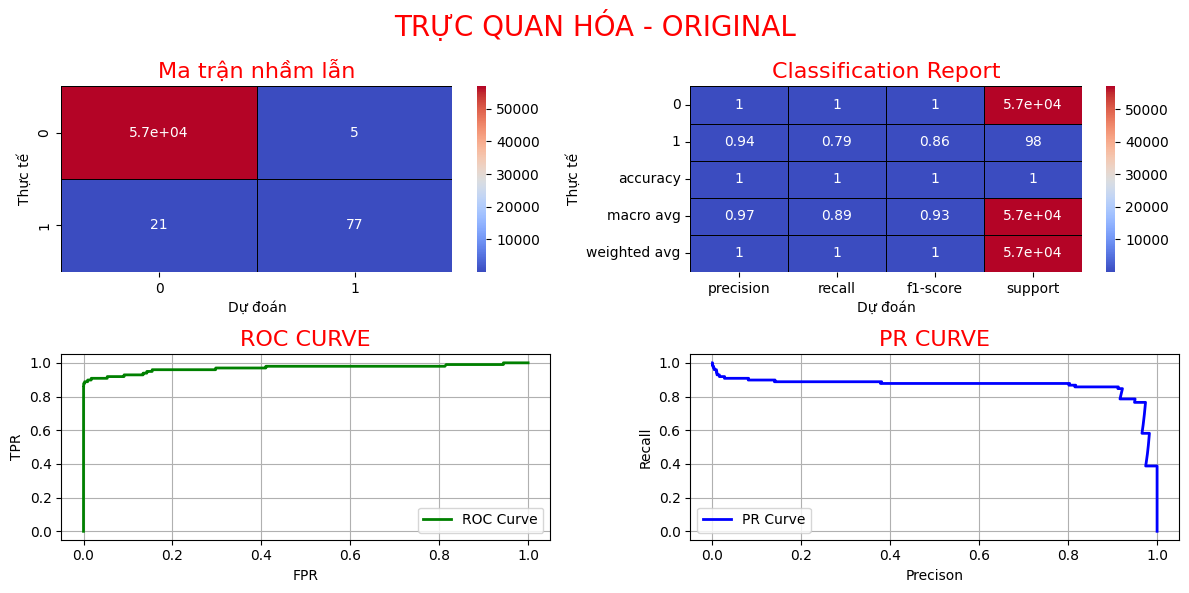

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
HUẤN LUYỆN VỚI PHƯƠNG PHÁP XỬ LÝ DỮ LIỆU: UNDERSAMPLING
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Tiến hành đánh giá mô hình: 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Độ chính xác mô hình là:  0.9986482216214319
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Đã tính Ma trận nhầm lẫn! 
---------------------------------------

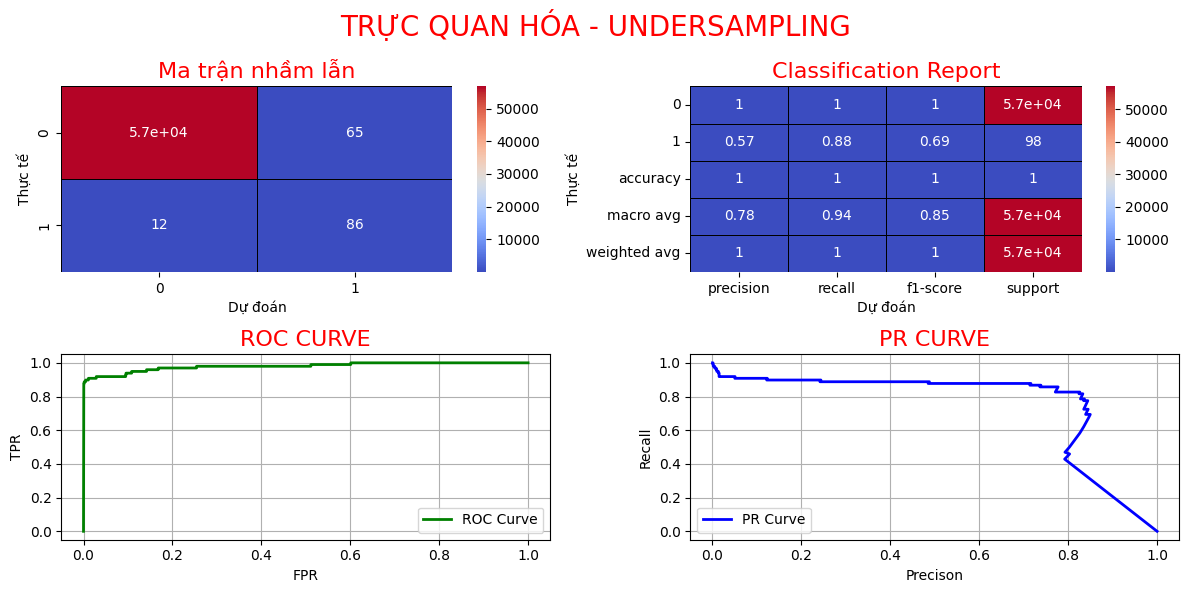

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
HUẤN LUYỆN VỚI PHƯƠNG PHÁP XỬ LÝ DỮ LIỆU: SMOTE
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Tiến hành đánh giá mô hình: 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Độ chính xác mô hình là:  0.9993153330290369
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Đã tính Ma trận nhầm lẫn! 
-----------------------------------------------

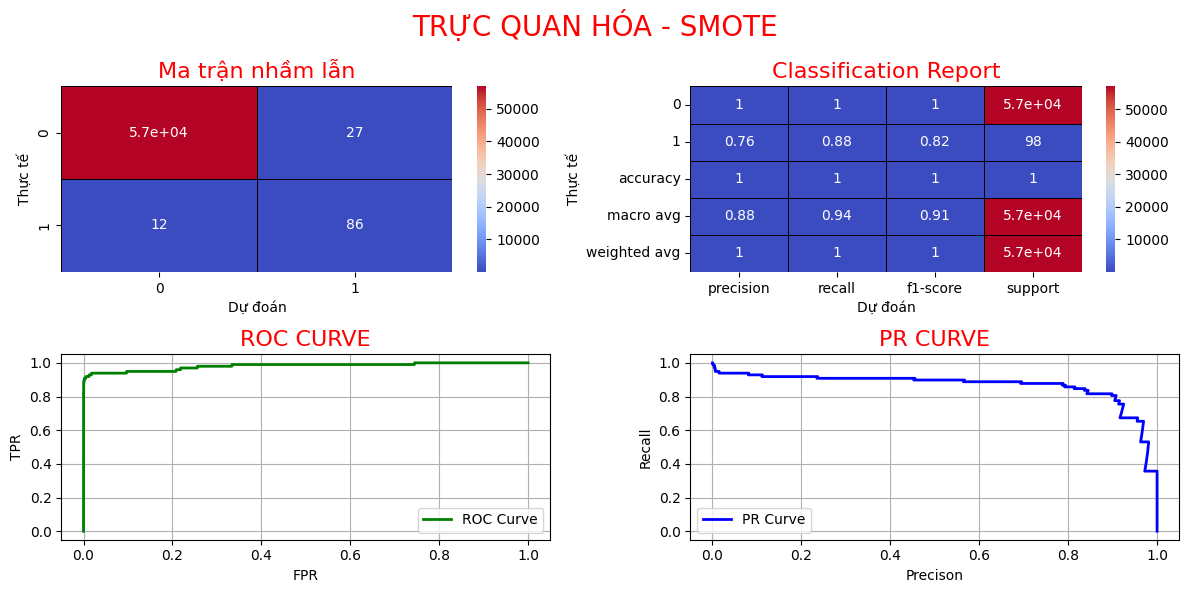

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
HUẤN LUYỆN VỚI PHƯƠNG PHÁP XỬ LÝ DỮ LIỆU: COMBINED
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Tiến hành đánh giá mô hình: 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Độ chính xác mô hình là:  0.9988939995084443
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Đã tính Ma trận nhầm lẫn! 
--------------------------------------------

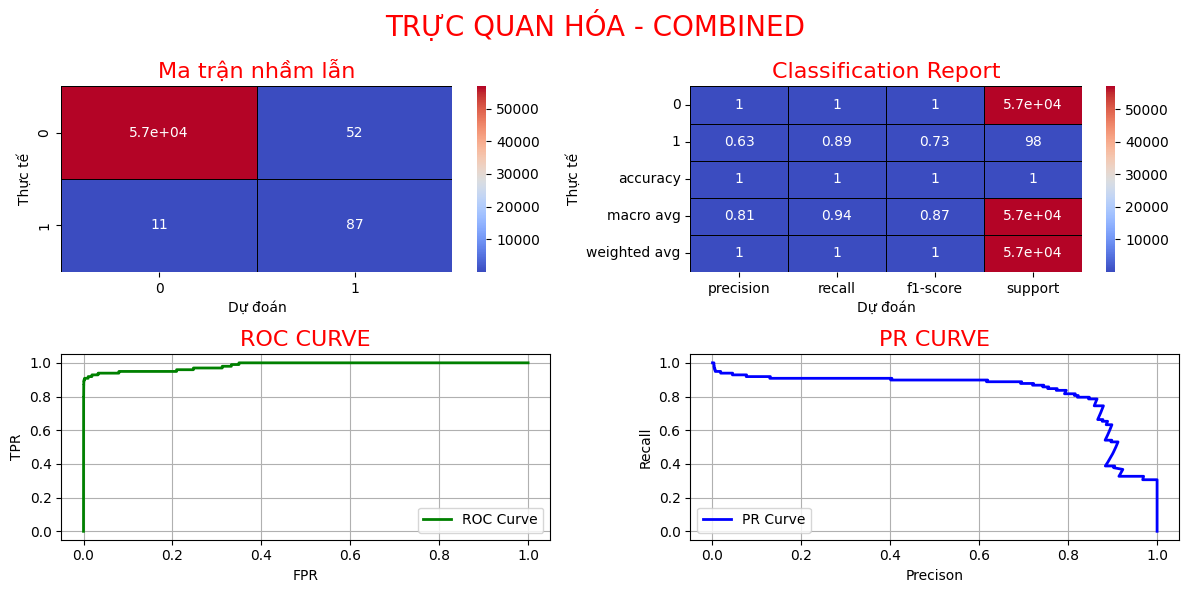

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [14]:
# Thực hành Huấn luyện và đánh giá mô hình

def train_and_evaluate_model(resampled_data, X_test, y_test):
  # RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'
    model = RandomForestClassifier(
        n_estimators = 50, #100
        max_depth = 10,  #15
        min_samples_split=5,
        random_state = 42,
        oob_score=True,
        n_jobs=-1,                     # Tận dụng toàn bộ CPU
        verbose=0
    )

    # Danh sách các phương pháp xử lý mất cân bằng
    resampling_methods = ['original', 'undersampling','smote', 'combined']

    # Lưu trữ kết quả
    results = []

    # Huấn luyện và đánh giá mô hình
    for method in resampling_methods:
        print("HUẤN LUYỆN VỚI PHƯƠNG PHÁP XỬ LÝ DỮ LIỆU:", method.upper())
        print("-"*200)

        X_train_resampled, y_train_resampled = resampled_data[method]

        # Huấn luyện mô hình
        model.fit(X_train_resampled, y_train_resampled)

        # Dự đoán
        y_pred = model.predict(X_test)

        # Tính Predict_Proba
        y_prob = model.predict_proba(X_test)[:, 1]

        # Đánh giá mô hình:
        result = eva_and_viz_model(model, X_test, y_test, y_pred, y_prob, method)
        results.append(result)
        print('-'*200)

    return results

results = train_and_evaluate_model(resampled_data, X_test, y_test)


In [15]:
def select_best_method(results):
    print("CHỌN PHƯƠNG PHÁP XỬ LÝ TỐT NHẤT")
    print("-"*100)
    # Truy cập vào từ danh sách từ điển results, truy cập đến key: 'pr_auc'
    # So sánh value của key này, tìm value max
    best_pr_auc = -np.inf
    best_method = None
    for method in results:
        if method['pr_auc'] > best_pr_auc:
            best_method = method['solu']
            best_pr_auc = method['pr_auc']

    print(f"Phương pháp xử lý mất cân bằng tốt nhất là: {best_method.upper()}, với PR_AUC = {best_pr_auc:.4f} ")
    print("-"*100)
    return best_method

best_method = select_best_method(results)

CHỌN PHƯƠNG PHÁP XỬ LÝ TỐT NHẤT
----------------------------------------------------------------------------------------------------
Phương pháp xử lý mất cân bằng tốt nhất là: SMOTE, với PR_AUC = 0.8679 
----------------------------------------------------------------------------------------------------


In [16]:
def optimize_best_model(best_method, resampled_data, X_test, y_test):
    print('TỐI ƯU HÓA MÔ HÌNH')
    print("-"*100)

    # 7.0. Lấy dữ liệu huấn luyện
    X_train, y_train = resampled_data[best_method]
    # 7.1. Khởi tạo mô hình
    model = RandomForestClassifier(random_state =  42)

    # 7.2. Khai báo các siêu tham số cần thử
    param_grid = {
        'n_estimators': np.arange(20,100,40).tolist(),
        #'max_depth': np.arange(5,21,5).tolist(),
        'class_weight': [None, 'balanced']
    }
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    # 7.4 Dùng GridSearchCV để thử các tổ hợp siêu tham số
    grid = GridSearchCV(
        estimator = model,
        param_grid = param_grid,
        cv = skf,
        scoring = 'average_precision',
        n_jobs = -1,
        verbose = 1
        )
    print("Đang thực hiện tìm kiếm lưới")
    grid.fit(X_train, y_train)

    print("Best Params:", grid.best_params_)
    print("Best Score:", grid.best_score_)

    return grid.best_estimator_

best_model = optimize_best_model(best_method, resampled_data, X_test, y_test)

TỐI ƯU HÓA MÔ HÌNH
----------------------------------------------------------------------------------------------------
Đang thực hiện tìm kiếm lưới
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params: {'class_weight': 'balanced', 'n_estimators': 60}
Best Score: 0.9997662468825069


TỐI ƯU HÓA MÔ HÌNH
----------------------------------------------------------------------------------------------------
Đang thực hiện tìm kiếm lưới
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params: {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 90}
Best Score: 0.9998428606709104
Tiến hành đánh giá mô hình: 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Độ chính xác mô hình là:  0.9994382219725431
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Đã tính Ma trận nhầm lẫn! 
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

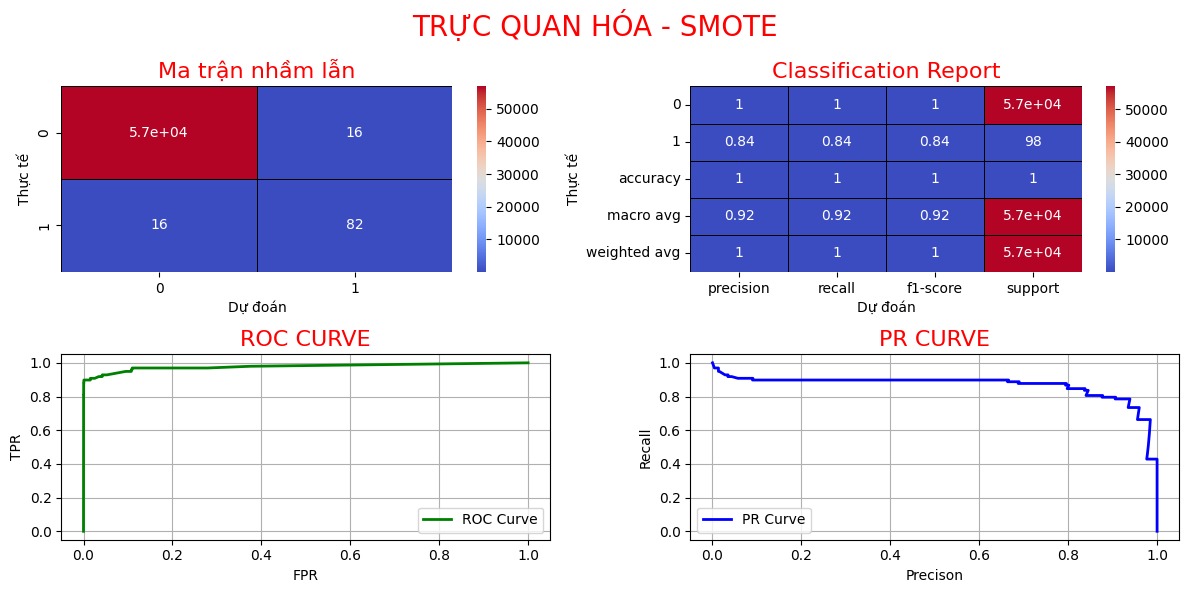

In [18]:
def optimize_best_model(best_method, resampled_data, X_test, y_test):
    print('TỐI ƯU HÓA MÔ HÌNH')
    print("-"*100)

    # 7.0. Lấy dữ liệu huấn luyện
    X_train, y_train = resampled_data[best_method]
    # 7.1. Khởi tạo mô hình
    model = RandomForestClassifier(random_state =  42)

    # 7.2. Khai báo các siêu tham số cần thử
    param_grid = {
        'n_estimators': np.arange(50,101,40).tolist(),
        'max_depth': np.arange(5,21,5).tolist(),
        'class_weight': [None, 'balanced']
    }
    # 7.3. Thiết lập cv với StratifiedKFOLD để giữ nguyên tỷ lệ phân phối các lớp
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    # 7.4 Dùng GridSearchCV để thử các tổ hợp siêu tham số
    grid = GridSearchCV(
        estimator = model,
        param_grid = param_grid,
        cv = skf,
        scoring = 'average_precision',
        n_jobs = -1,
        verbose = 1
        )
    print("Đang thực hiện tìm kiếm lưới")
    grid.fit(X_train, y_train)

    print("Best Params:", grid.best_params_)
    print("Best Score:", grid.best_score_)

    return grid.best_estimator_

best_model = optimize_best_model(best_method, resampled_data, X_test, y_test)

y_pred = best_model.predict(X_test)

y_prob = best_model.predict_proba(X_test)[:, 1]

result = eva_and_viz_model(best_model, X_test, y_test, y_pred, y_prob, best_method)

In [19]:
def find_optimal_threshold(best_model, X_test, y_test):
    print("TÌM NGƯỠNG TỐI ƯU CHO MÔ HÌNH")
    print("-"*100)

    y_probs = best_model.predict_proba(X_test)[:,1]

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

    #  f1_score = 2*P*R/(P+R)

    f1_scores = pd.DataFrame(2 * precisions[:-1] * recalls[:-1] / (precisions[:-1] + recalls[:-1]))
    # [:-1]: lấy tất cả phần tử trừ phần tử cuối cùng
    precisions = pd.DataFrame(precisions[:-1])
    recalls = pd.DataFrame(recalls[:-1])

    r_idx = recalls[0] > 0.85

    precisions = precisions[r_idx].reset_index(drop = True).dropna()
    print(precisions)
    recalls = recalls[r_idx].reset_index(drop = True).dropna()
    f1_scores = f1_scores[r_idx].reset_index(drop = True).dropna()
    print(f1_scores)

    # Tìm ngưỡng có F1_score cao nhất
    optimal_idx = np.argmax(f1_scores)
    print(optimal_idx)

    optimal_threshold = thresholds[optimal_idx]

    # In ra kết quả:
    print(f"Ngưỡng tối ưu là: {optimal_threshold}")
    print(f"F1-score tối ưu là: {f1_scores.iloc[optimal_idx,0]}")
    print(f"Precision tối ưu là: {precisions.iloc[optimal_idx, 0]}")
    print(f"Recall tối ưu là: {recalls.iloc[optimal_idx, 0]}")
    print("-"*100)

best_threshold = find_optimal_threshold(best_model, X_test, y_test)

TÌM NGƯỠNG TỐI ƯU CHO MÔ HÌNH
----------------------------------------------------------------------------------------------------
             0
0     0.001720
1     0.004480
2     0.005951
3     0.007041
4     0.007065
...        ...
2586  0.788991
2587  0.796296
2588  0.794393
2589  0.801887
2590  0.800000

[2591 rows x 1 columns]
             0
0     0.003435
1     0.008920
2     0.011828
3     0.013981
4     0.014028
...        ...
2586  0.830918
2587  0.834951
2588  0.829268
2589  0.833333
2590  0.827586

[2591 rows x 1 columns]
2587
Ngưỡng tối ưu là: 0.38873484506706885
F1-score tối ưu là: 0.8349514563106796
Precision tối ưu là: 0.7962962962962963
Recall tối ưu là: 0.8775510204081632
----------------------------------------------------------------------------------------------------


Tiến hành đánh giá mô hình: 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Độ chính xác mô hình là:  0.9994382219725431
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Đã tính Ma trận nhầm lẫn! 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Đã tính Classification Report! 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Đã tính ROC-AUC!
----------------------------------------------

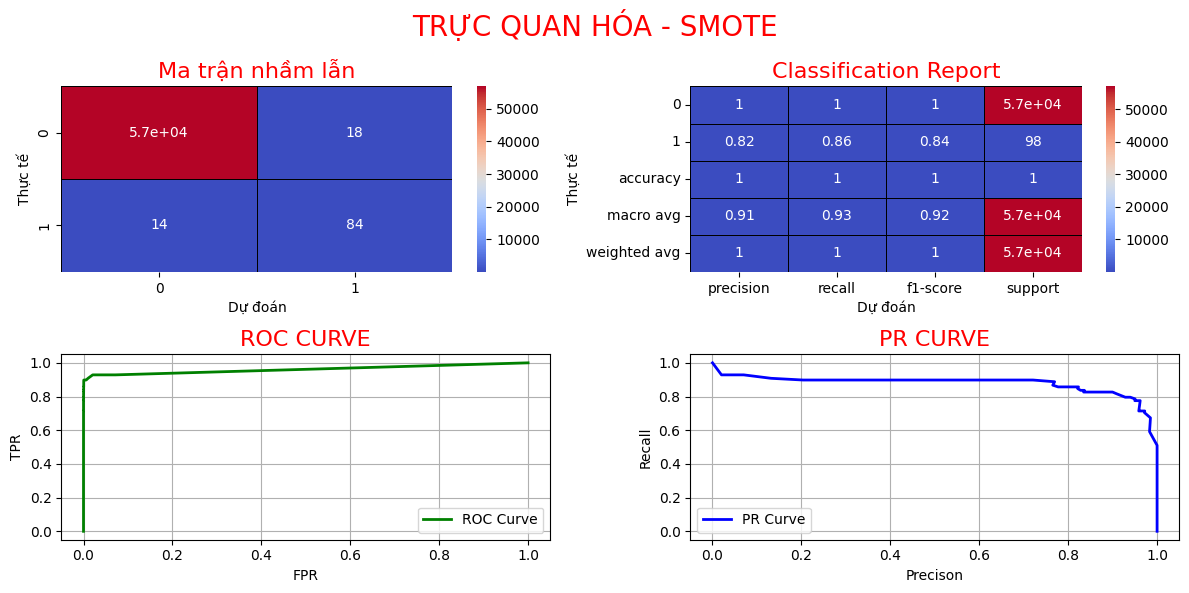

In [20]:
best_model = RandomForestClassifier(
    class_weight = 'balanced',
    n_estimators = 60,
    n_jobs = -1,
    verbose = 0,
    random_state = 42
)

X_train_end, y_train_end = resampled_data[best_method]

# Huấn luyện mô hình
best_model.fit(X_train_end, y_train_end)

# # Đánh giá mô hình, tìm y_pred
# y_pred = best_model.predict(X_test)

# Ngưỡng tối ưu
best_threshold = 0.38333333333333336

# Tính xác suất dự đoán predict_proba
y_prob = best_model.predict_proba(X_test)[:, 1]

# Đánh giá mô hình
y_pred = (y_prob >= best_threshold).astype(int)

eva_end_model = eva_and_viz_model(best_model, X_test, y_test, y_pred, y_prob, best_method)

In [21]:
import joblib

joblib.dump(best_model, "credit_card_fraud_detection_rf.pkl")
print("Mô hình đã được lưu!")

Mô hình đã được lưu!


In [22]:
from google.colab import files
files.download('credit_card_fraud_detection_rf.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>